<a href="https://colab.research.google.com/github/ebagdasa/federated/blob/old_m/analytics/location_heatmaps/dp_location_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Location Heatmaps under Distributed Differential Privacy with Secure Aggregation

This code shows examples of the proposed algorithm from [PETS'22 paper](https://arxiv.org/abs/2111.02356). We use publicly available [map](https://www.nytimes.com/2018/12/14/reader-center/phone-data-location-investigation.html) from the NYTimes article and population density from [Facebook Humanitarian Data Project](https://data.humdata.org/organization/facebook).


To cite our work use:
```
@inproceedings{bagdasaryan2022sparse,
      title={Towards Sparse Federated Analytics: Location Heatmaps under Distributed Differential Privacy with Secure Aggregation}, 
      author={Eugene Bagdasaryan and Peter Kairouz and Stefan Mellem and Adrià Gascón and Kallista Bonawitz and Deborah Estrin and Marco Gruteser},
      year={2022},
      bootkitle={PETS},
}
```




In [1]:
!git clone https://github.com/google-research/federated.git

Cloning into 'federated'...
remote: Enumerating objects: 3701, done.
remote: Counting objects: 100% (1030/1030), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 3701 (delta 919), reused 883 (delta 872), pack-reused 2671
Receiving objects: 100% (3701/3701), 13.15 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (2595/2595), done.


In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
!pip install torch
!pip install matplotlib
!pip install tqdm
!pip install pygtrie

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pygtrie: filename=pygtrie-2.5.0-py3-none-any.whl size=20944 sha256=e82980bbb446b127e5c0822c748f7b4f739134a90e5329d62e5945ddc12d6154
  Stored in directory: /root/.cache/pip/wheels/d1/5b/c8/7791f519f0b9f7186bd7531fe8749a849934739069ee2f2a43
Successfully built pygtrie


In [14]:
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm

In [15]:
import sys
sys.path.insert(1, "federated/analytics/location_heatmaps")

In [16]:
from run_experiment import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import geo_utils
import metrics
import mechanisms

In [17]:
# Original source:
# !wget https://static01.nyt.com/images/2018/12/14/business/10location-insider/10location-promo-superJumbo-v2.jpg

!wget https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/location_heatmap.jpg

--2022-08-22 23:11:08--  https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/location_heatmap.jpg
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924651 (4.7M) [image/jpeg]
Saving to: ‘location_heatmap.jpg’

location_heatmap.jp 100%[===================>]   4.70M  2.50MB/s    in 1.9s    

2022-08-22 23:11:12 (2.50 MB/s) - ‘location_heatmap.jpg’ saved [4924651/4924651]



In [18]:
true_image, dataset = get_data('location_heatmap.jpg')

100%|██████████| 1024/1024 [00:25<00:00, 40.96it/s]


In [19]:
print(f'Total users on the map: {true_image.sum():,}.')

Total users on the map: 54,599,988.


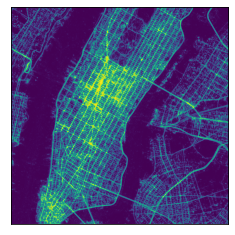

In [20]:
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(true_image)

## Algorithm design

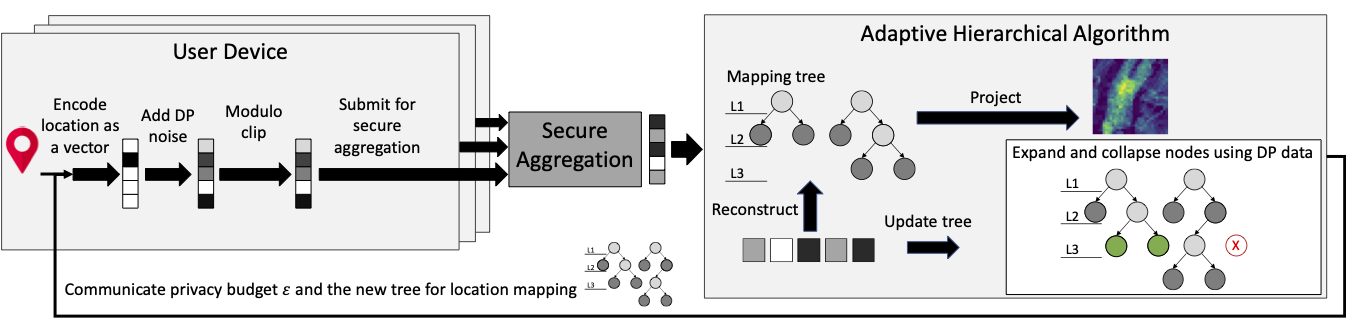

Briefly, our algorithm iteratively explores regions collapsing and expanding depending on the provided dynamic thresholds. It also plans the privacy budget depending on the result obtained from the previous round of the algorithm. 

To achieve differential privacy under secure aggregation we use distributed geometric noise (see Section 4). We set SecAgg shard size to 10,000.

### No DP

We begin with a sample run, with 10k

has_aux_bit: False
Total of 10.0 SecAgg rounds per level
Level: 0. Eps: None. Threshold: 10.00. Remaining: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 0. MSE: 9.66e-11, without sampling error: 1.35e-12.
New: 16. Collapsed: 0. Created from collapsed: 0. Unchanged: 0.
Level: 1. Eps: None. Threshold: 10.00. Remaining: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 1. MSE: 9.63e-11, without sampling error: 1.09e-12.
New: 64. Collapsed: 0. Created from collapsed: 0. Unchanged: 0.
Level: 2. Eps: None. Threshold: 10.00. Remaining: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 2. MSE: 9.61e-11, without sampling error: 8.83e-13.
New: 256. Collapsed: 0. Created from collapsed: 0. Unchanged: 0.
Level: 3. Eps: None. Threshold: 10.00. Remaining: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 3. MSE: 9.60e-11, without sampling error: 7.79e-13.
New: 796. Collapsed: 0. Created from collapsed: 0. Unchanged: 57.
Level: 4. Eps: None. Threshold: 10.00. Remaining: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 4. MSE: 9.58e-11, without sampling error: 7.75e-13.
New: 1580. Collapsed: 0. Created from collapsed: 0. Unchanged: 458.
Level: 5. Eps: None. Threshold: 10.00. Remaining: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 5. MSE: 9.57e-11, without sampling error: 9.21e-13.
New: 256. Collapsed: 0. Created from collapsed: 0. Unchanged: 1974.
Level: 6. Eps: None. Threshold: 10.00. Remaining: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 6. MSE: 9.58e-11, without sampling error: 9.48e-13.
New: 0. Collapsed: 0. Created from collapsed: 0. Unchanged: 2230.
Total epsilon-users: 0.00 with 0.00 eps per person. 


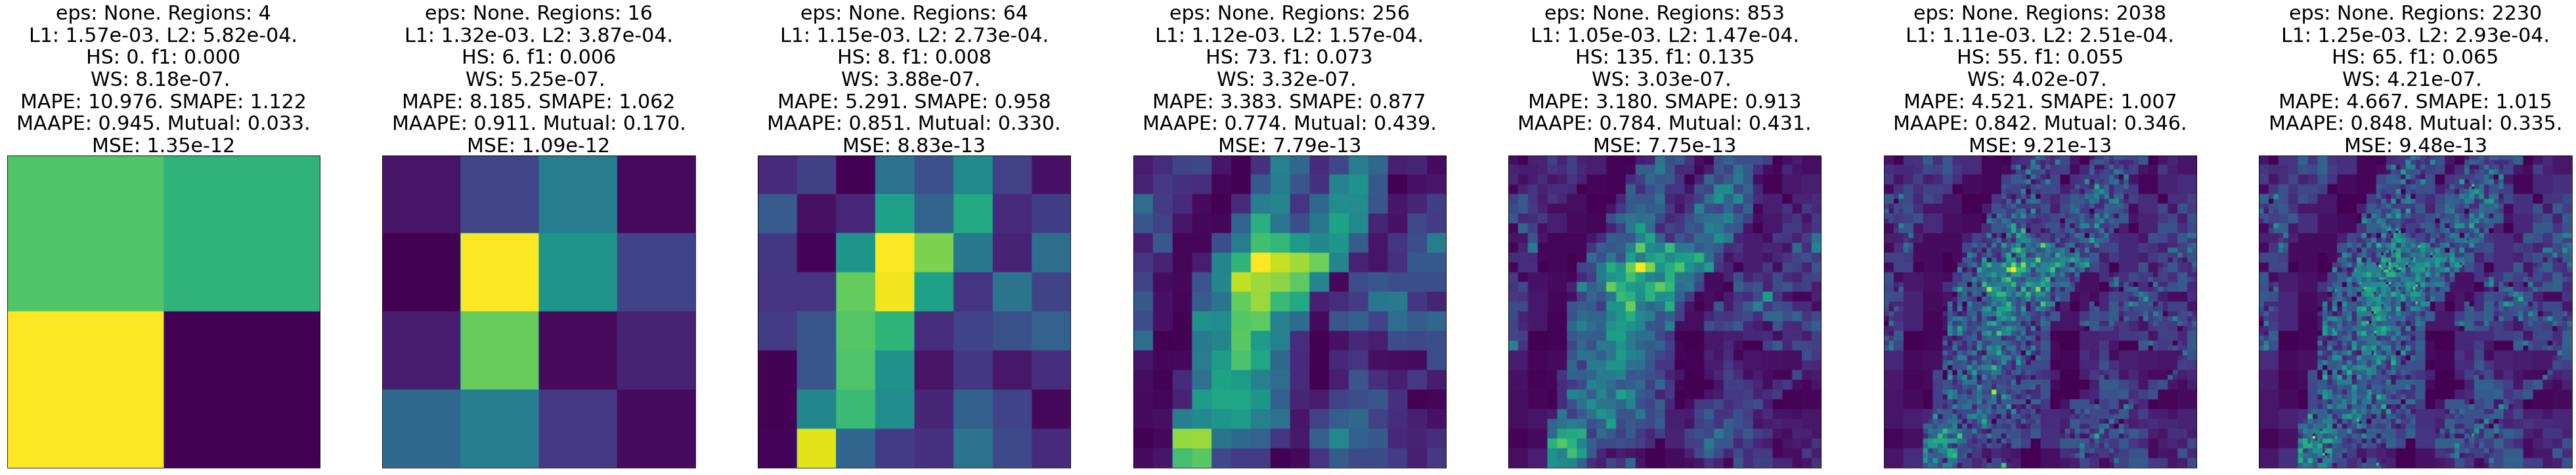

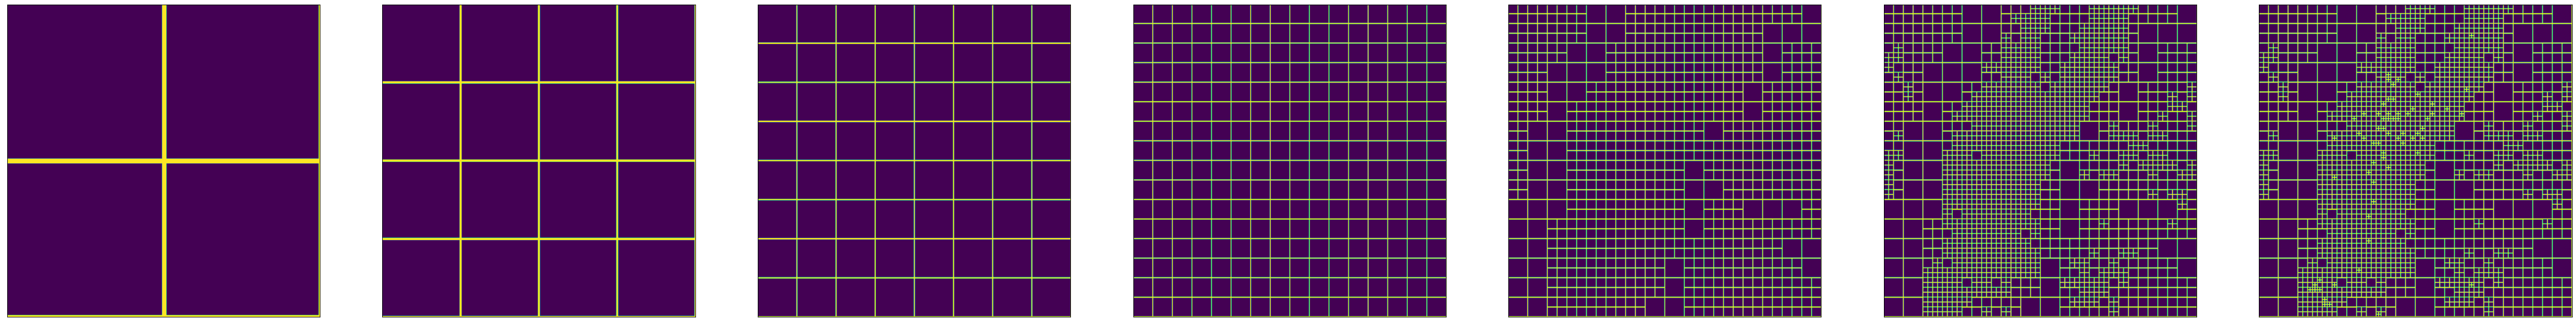

In [22]:
users = 10000
secagg_size = 1000
c = secagg_size / users
res10_nodp = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: None,
                   split_threshold=10,
                   top_k=TOPK,
                   partial=1,
                   max_levels=7,
                   total_size=TOTAL_SIZE,
                   min_dp_size=None,
                   dropout_rate=None,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   has_aux_bit=False, start_with_level=-1,
                   last_result_ci=False)

In [ ]:
len(res10_nodp)

7

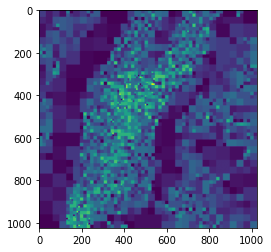

In [ ]:
plt.imshow(res10_nodp[-1].image)

## Main result

For each level of the algorithm we use method `get_eps_from_two_std()` that computes budget using Equation 8, i.e. it assures that the produced noise is proportional to an approximate ratio of users to a number of sub-regions.

```python
mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions)
```

aux_data: False
Total of 1.0 SecAgg rounds per level
Level: 0. Eps: 0.01131364816007492. Threshold: 250.00. Remaining: 1.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 0. MSE: 9.67e-11, without sampling error: 1.36e-12.
Level: 1. Eps: 0.04525097313957988. Threshold: 62.50. Remaining: 0.99


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 1. MSE: 9.64e-11, without sampling error: 1.09e-12.
Level: 2. Eps: 0.18077309093243188. Threshold: 15.62. Remaining: 0.94


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 2. MSE: 9.62e-11, without sampling error: 8.87e-13.
Last round. Spending remaining epsilon budget: 7626.622877679133
Level: 3. Eps: 0.7626622877679133. Threshold: 3.62. Remaining: 0.76


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 3. MSE: 9.61e-11, without sampling error: 7.88e-13.
Total epsilon-users: 10000.00 with 1.00 eps per person. 


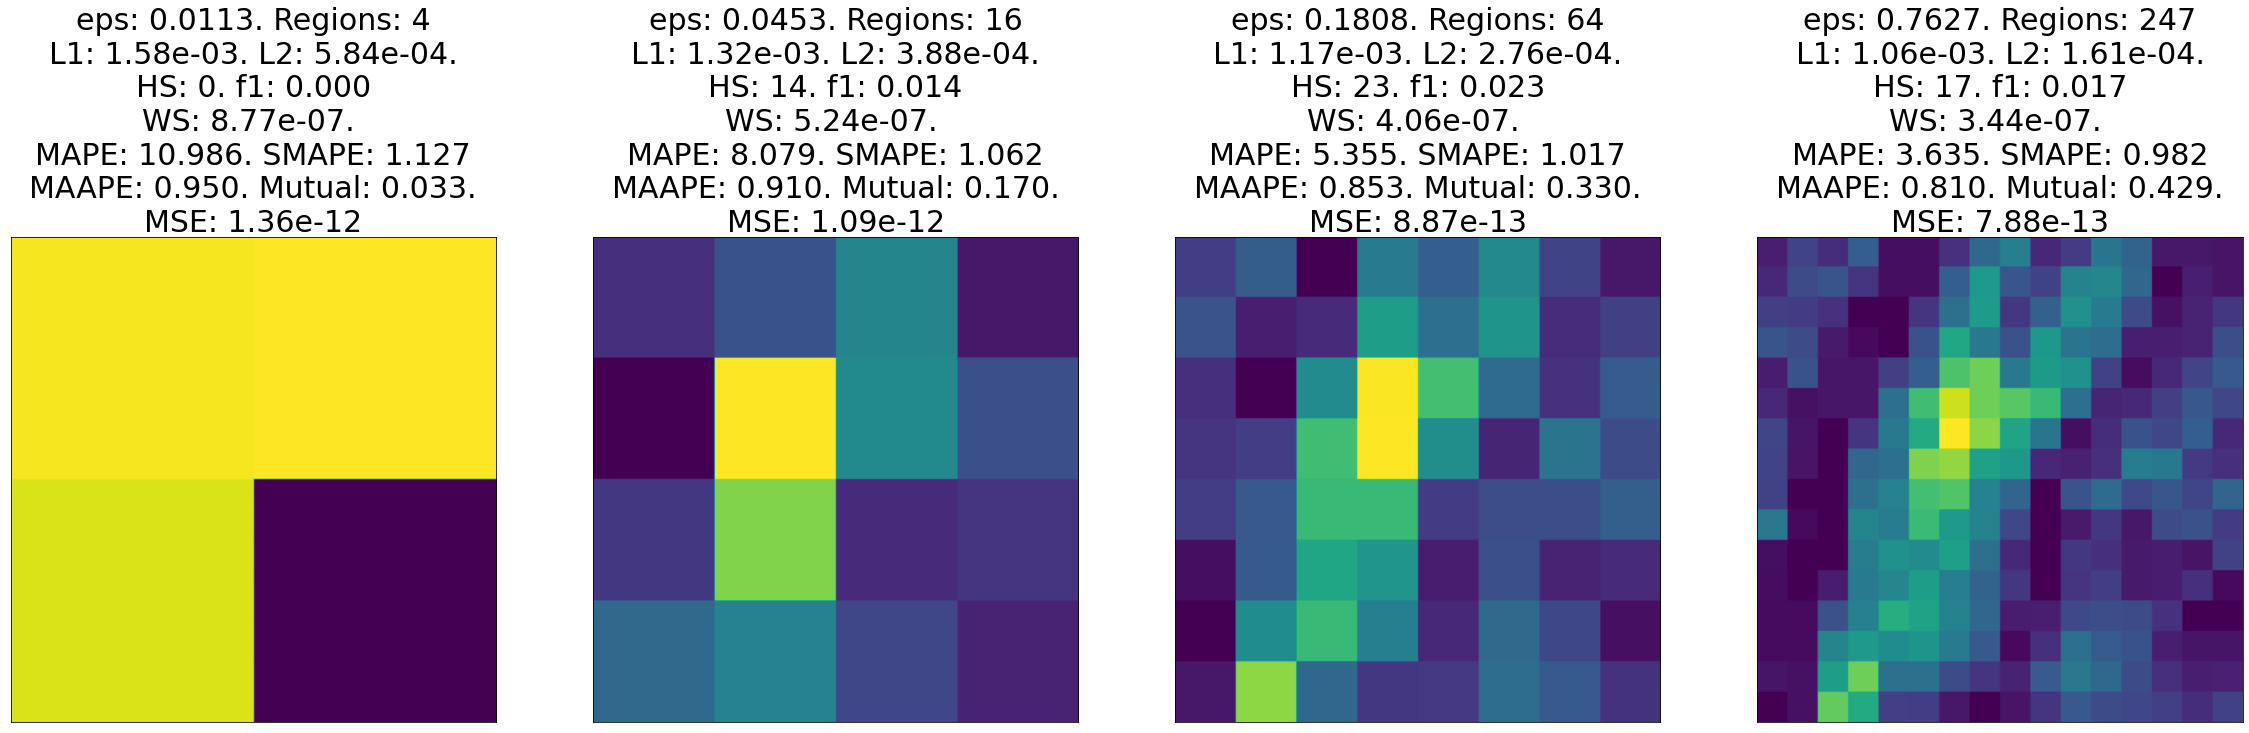

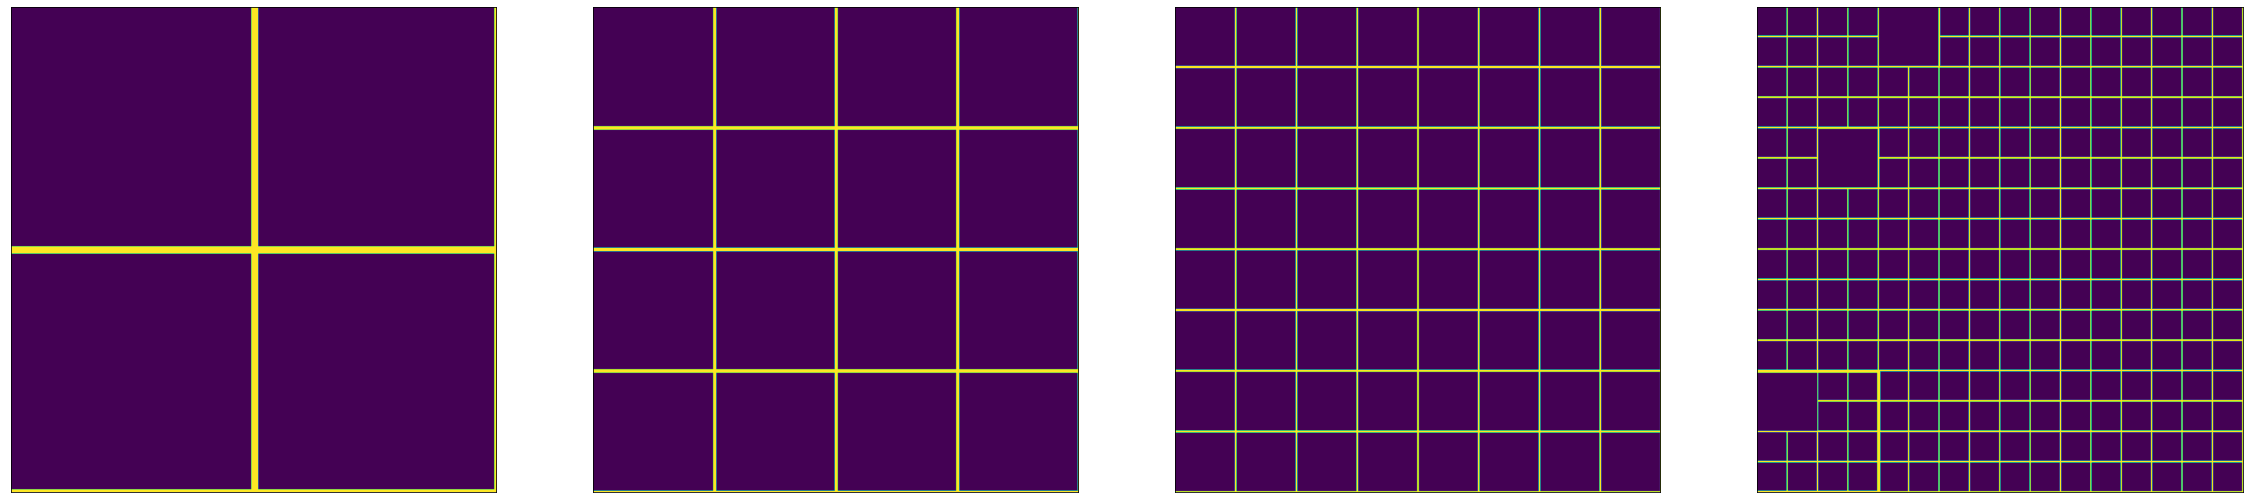

In [ ]:
users = 10000
secagg_size = 10000
c = 1/10
res10k = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   split_threshold_func=lambda i, prefix_len, eps, remaining: 2 / np.sqrt(secagg_size / users) * mechanisms.get_std_from_eps( eps),
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   has_aux_bit=False, start_with_level=-1,
                   last_result_ci=False)


### Main result 2: 100K users with 10% dropout and distributed DP

has_aux_bit: False
Total of 10.0 SecAgg rounds per level
Level: 0. Eps: 0.003577706855891111. Threshold: 2500.00. Remaining: 1.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 0. MSE: 1.09e-11, without sampling error: 1.35e-12.
New: 16. Collapsed: 0. Created from collapsed: 0. Unchanged: 0.
Level: 1. Eps: 0.014310712939686405. Threshold: 625.00. Remaining: 1.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 1. MSE: 1.06e-11, without sampling error: 1.09e-12.
New: 64. Collapsed: 0. Created from collapsed: 0. Unchanged: 0.
Level: 2. Eps: 0.05723552747969013. Threshold: 156.25. Remaining: 0.98


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 2. MSE: 1.04e-11, without sampling error: 8.84e-13.
New: 244. Collapsed: 0. Created from collapsed: 0. Unchanged: 3.
Level: 3. Eps: 0.22047668787779587. Threshold: 40.49. Remaining: 0.92


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 3. MSE: 1.03e-11, without sampling error: 7.67e-13.
New: 892. Collapsed: 10. Created from collapsed: 9. Unchanged: 14.
Last round. Spending remaining epsilon budget: 70439.93648469365
Level: 4. Eps: 0.7043993648469365. Threshold: 12.44. Remaining: 0.70


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 4. MSE: 1.02e-11, without sampling error: 7.03e-13.
New: 3227. Collapsed: 57. Created from collapsed: 36. Unchanged: 50.
Total epsilon-users: 100000.00 with 1.00 eps per person. 


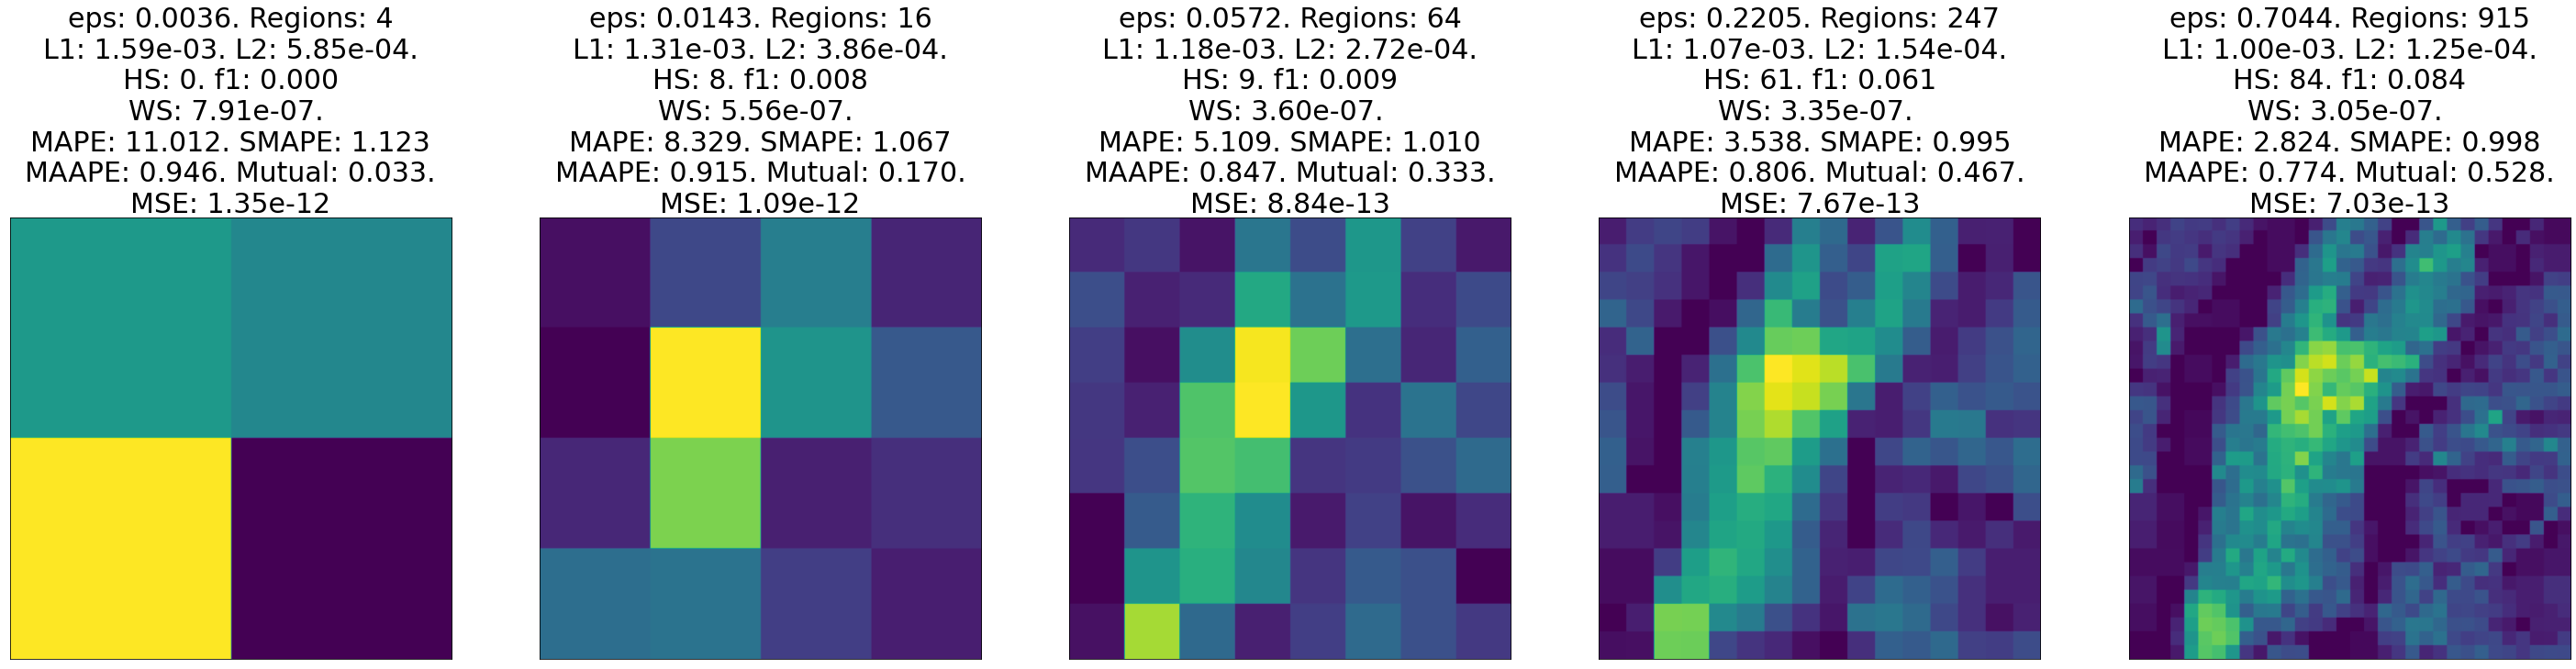

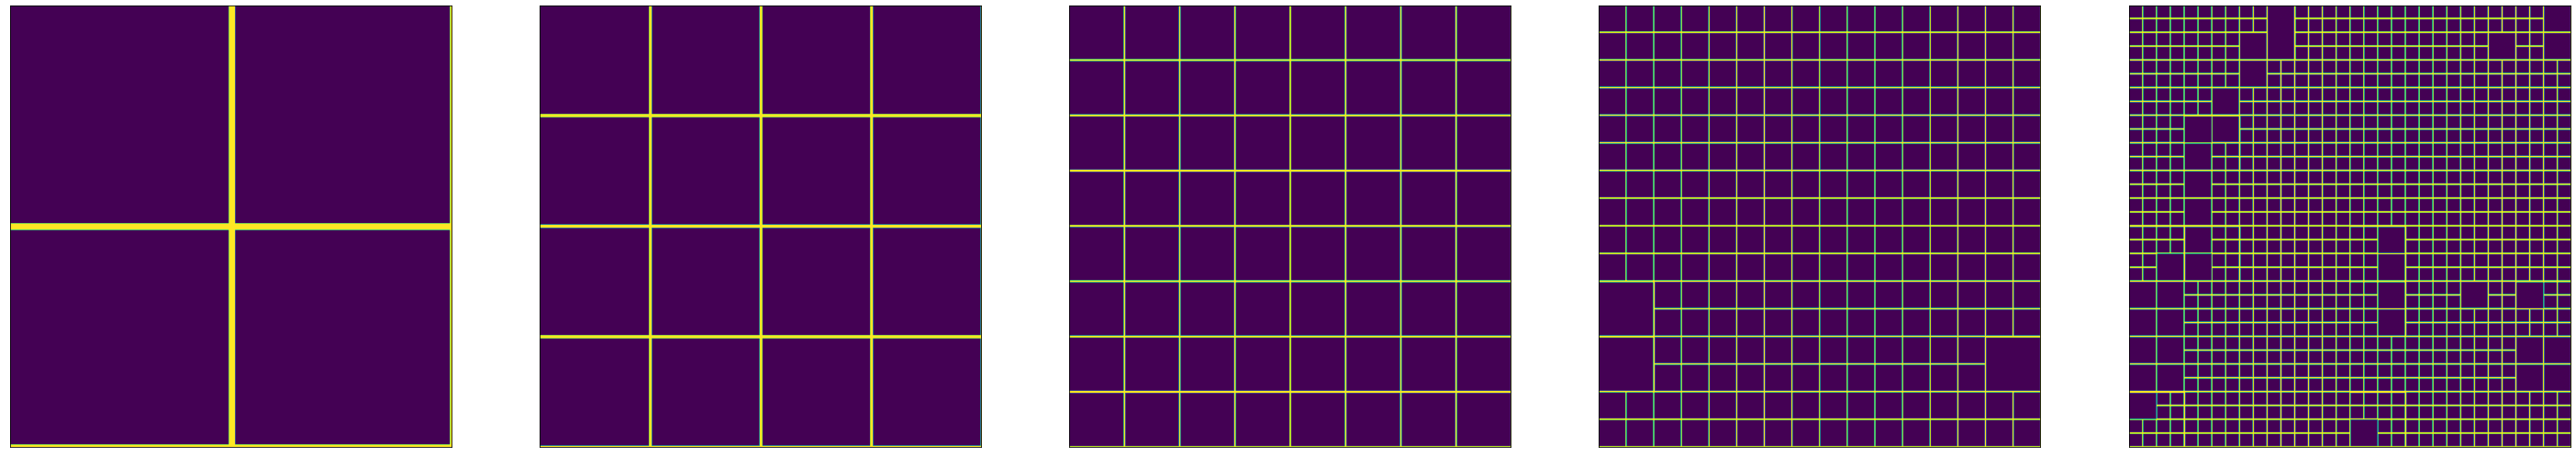

In [23]:
users = 100000
secagg_size = 10000
c = 1/10
res100k = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   split_threshold_func=lambda i, prefix_len, eps, remaining: 2 / np.sqrt(secagg_size / users) * mechanisms.get_std_from_eps(eps),
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   min_dp_size=9000,
                   dropout_rate=0.1,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   has_aux_bit=False, start_with_level=-1,
                   last_result_ci=False)


In [ ]:
plotting.animate_gif(res100k)

due to dropout less reported data for level: 2.
due to dropout less reported data for level: 2.
due to dropout less reported data for level: 2.
due to dropout less reported data for level: 2.
due to dropout less reported data for level: 3.
due to dropout less reported data for level: 3.


<Figure size 432x288 with 0 Axes>

## Comparing to different baselines 

Adaptive epsilon, fixed threshold=10

aux_data: False
Total of 1.0 SecAgg rounds per level
Level: 0. Eps: 0.01131364816007492. Threshold: 10.00. Remaining: 1.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 0. MSE: 9.66e-11, without sampling error: 1.35e-12.
Level: 1. Eps: 0.04525097313957988. Threshold: 10.00. Remaining: 0.99


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 1. MSE: 9.64e-11, without sampling error: 1.09e-12.
Level: 2. Eps: 0.18077309093243188. Threshold: 10.00. Remaining: 0.94


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 2. MSE: 9.62e-11, without sampling error: 8.85e-13.
Last round. Spending remaining epsilon budget: 7626.622877679133
Level: 3. Eps: 0.7626622877679133. Threshold: 10.00. Remaining: 0.76


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 3. MSE: 9.60e-11, without sampling error: 7.85e-13.
Total epsilon-users: 10000.00 with 1.00 eps per person. 


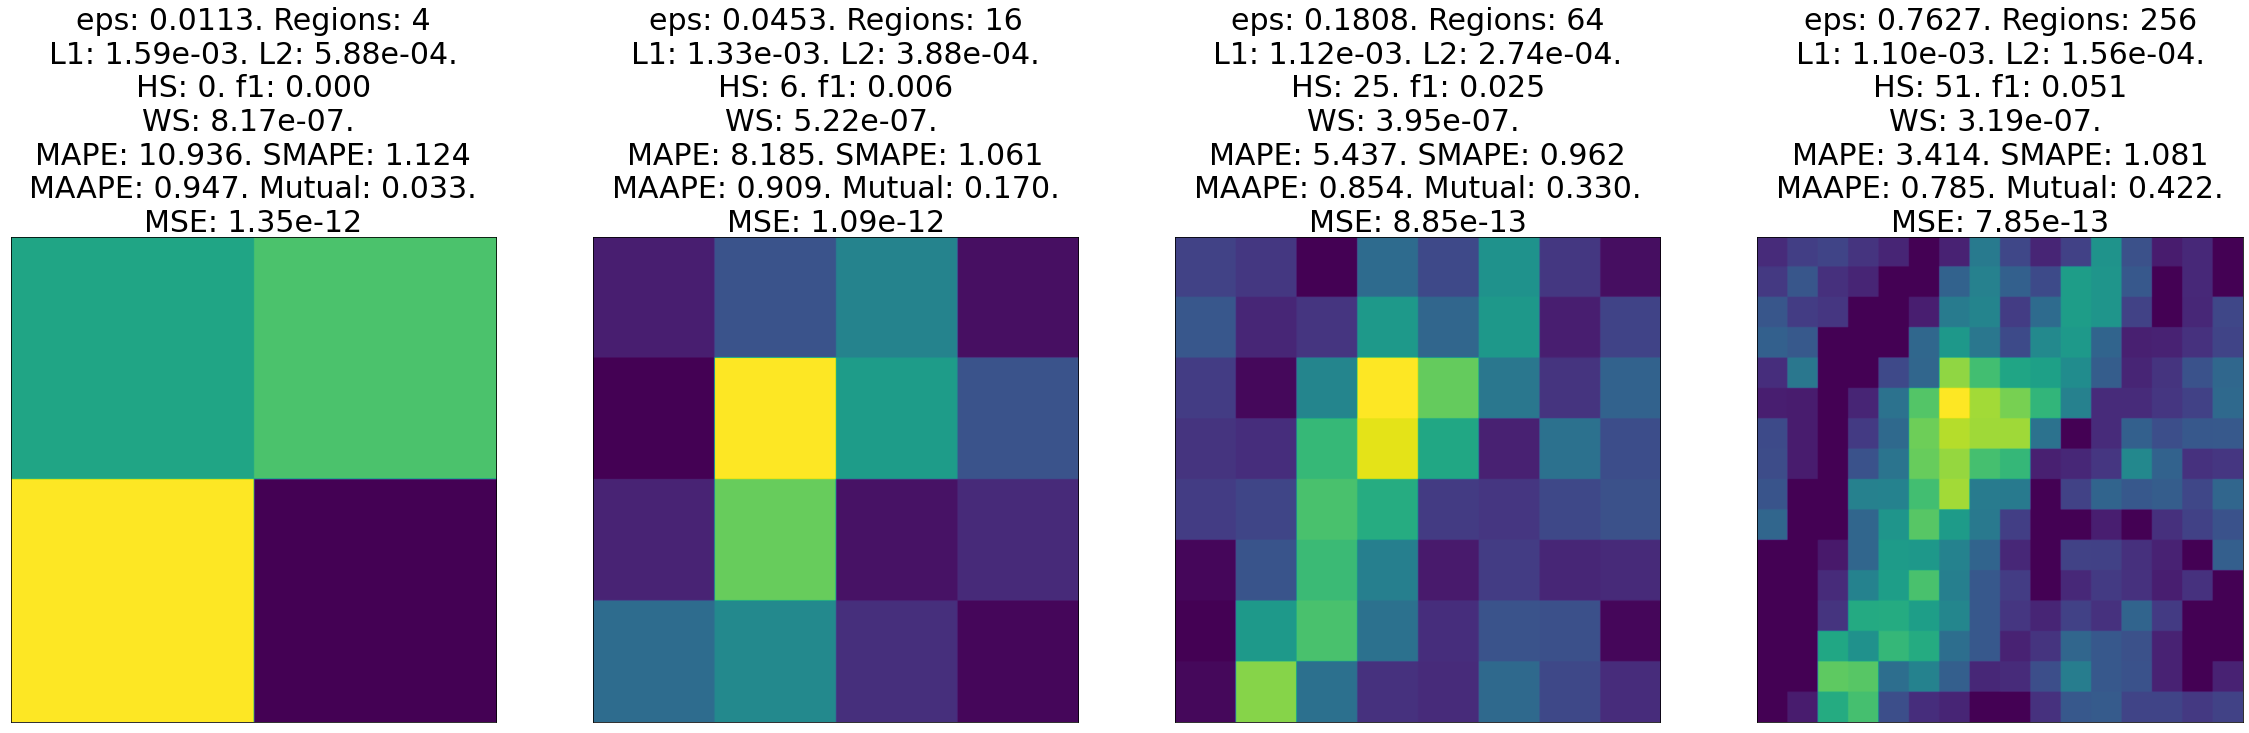

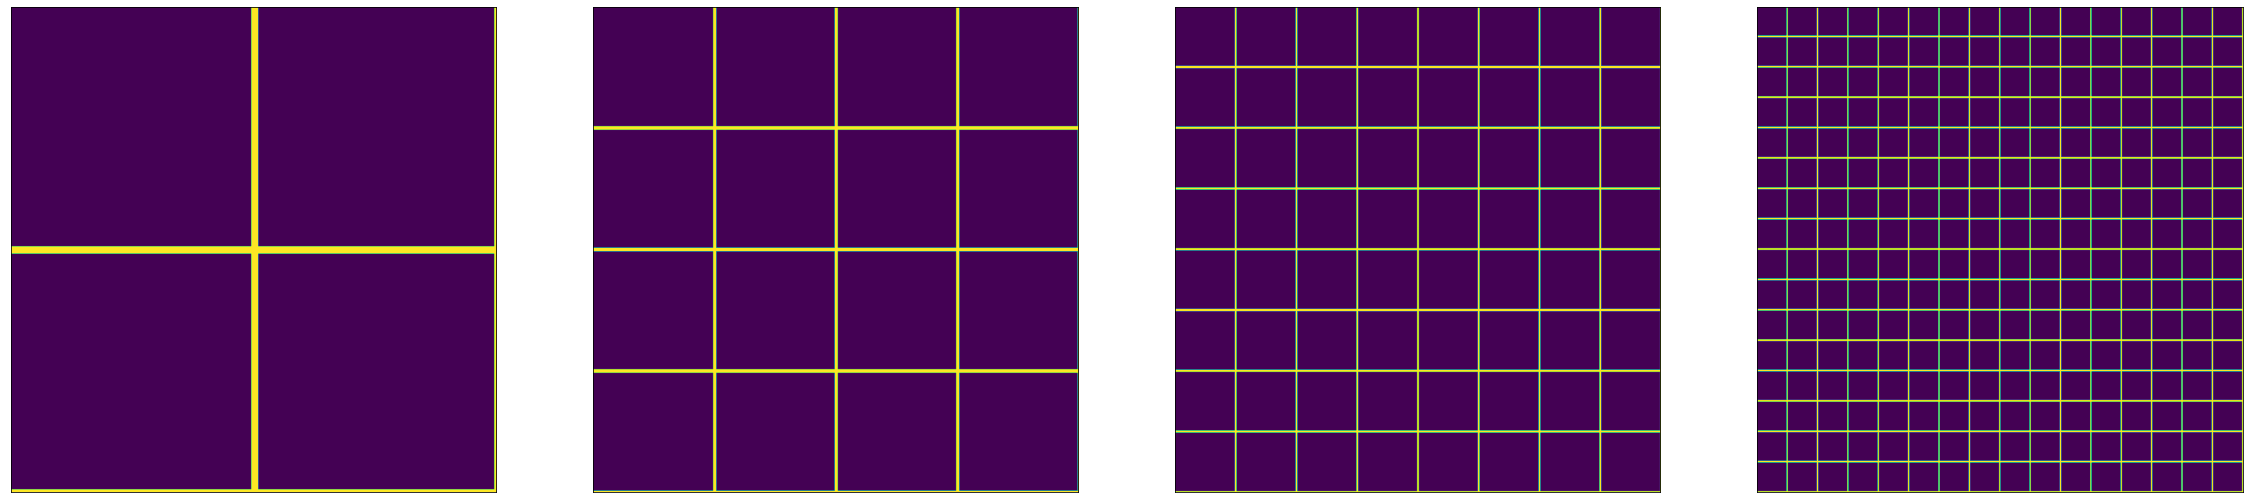

In [ ]:
users = 10000
secagg_size = 10000
c = 1/10
res10k = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   split_threshold_func=lambda i, prefix_len, eps, remaining: 10,
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   has_aux_bit=False, start_with_level=-1,
                   last_result_ci=False)


Fixed threshold, fixed epsilon

aux_data: False
Total of 1.0 SecAgg rounds per level
Level: 0. Eps: 0.1. Threshold: 10.00. Remaining: 1.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 0. MSE: 9.67e-11, without sampling error: 1.35e-12.
Level: 1. Eps: 0.1. Threshold: 10.00. Remaining: 0.90


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 1. MSE: 9.64e-11, without sampling error: 1.09e-12.
Level: 2. Eps: 0.1. Threshold: 10.00. Remaining: 0.80


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 2. MSE: 9.62e-11, without sampling error: 8.94e-13.
Level: 3. Eps: 0.1. Threshold: 10.00. Remaining: 0.70


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 3. MSE: 9.62e-11, without sampling error: 8.89e-13.
Level: 4. Eps: 0.1. Threshold: 10.00. Remaining: 0.60


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 4. MSE: 9.69e-11, without sampling error: 1.69e-12.
Last round. Spending remaining epsilon budget: 5000.0
Level: 5. Eps: 0.5. Threshold: 10.00. Remaining: 0.50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Level: 5. MSE: 9.82e-11, without sampling error: 3.17e-12.
Total epsilon-users: 10000.00 with 1.00 eps per person. 


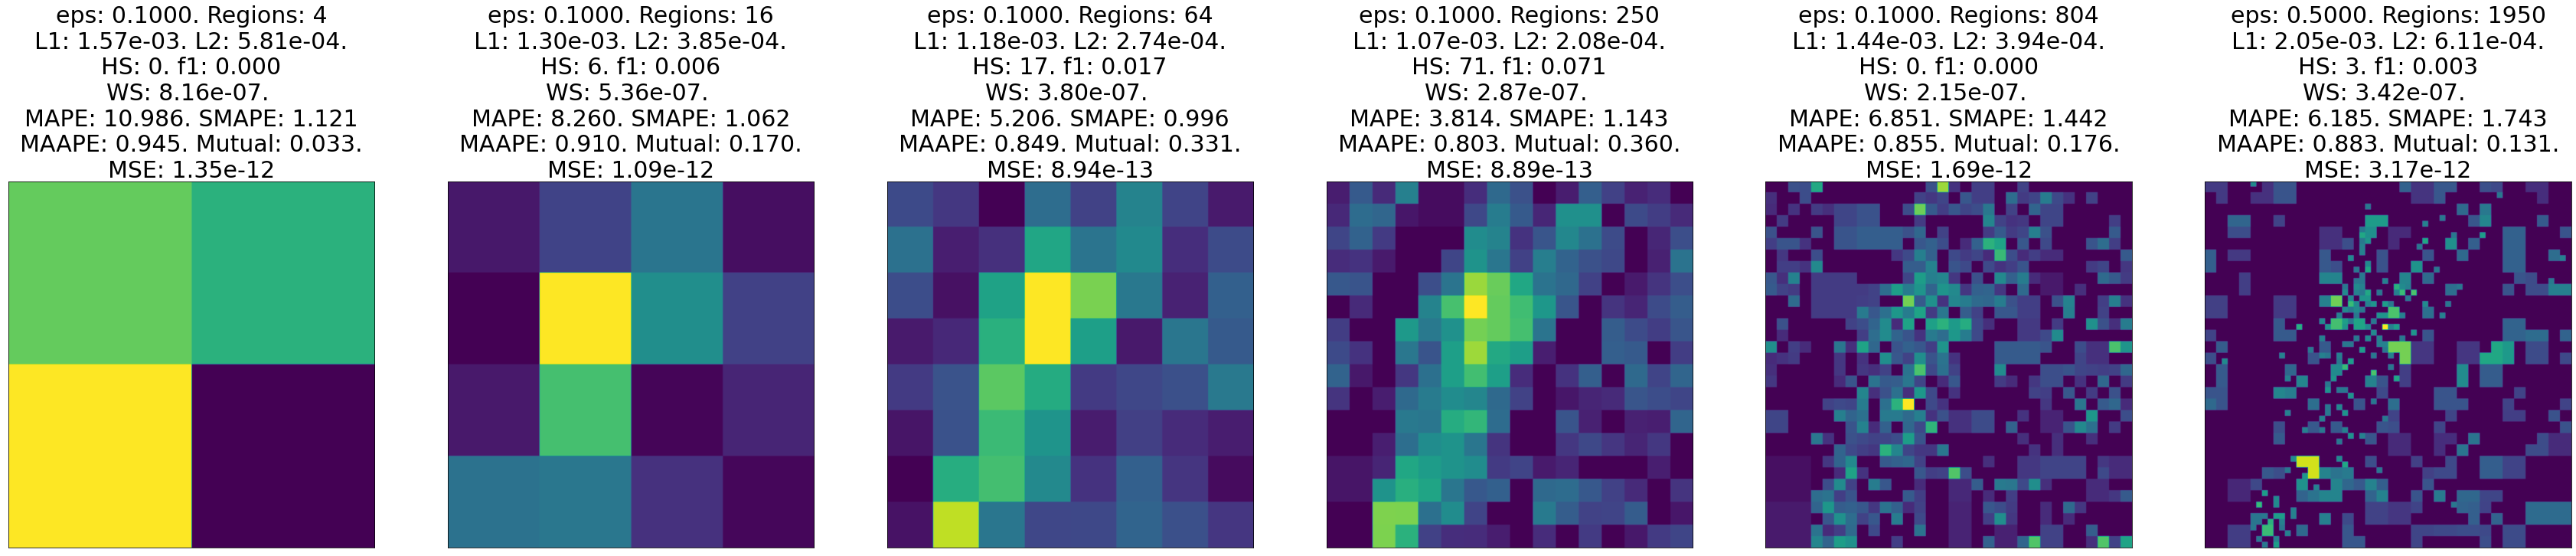

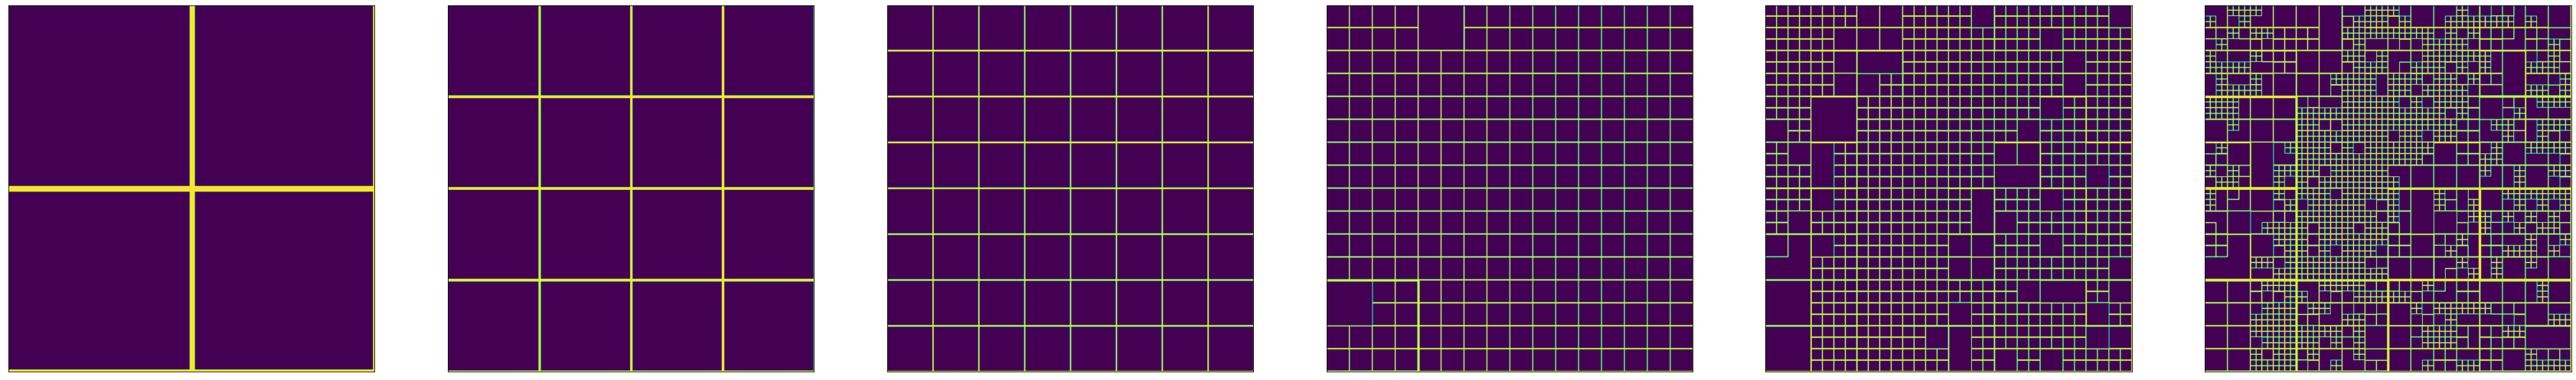

In [ ]:
users = 10000
secagg_size = 10000
c = 1/10
res10k = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: 0.1,
                   split_threshold_func=lambda i, prefix_len, eps, remaining: 10,
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=6,
                   total_size=TOTAL_SIZE,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   has_aux_bit=False, start_with_level=-1,
                   last_result_ci=False)


### Large number of users

positivity: False
Total of 100.0 SecAgg rounds per level


  0%|          | 1090/1000000 [00:00<01:31, 10894.58it/s]

Level: 0. Eps: 0.0011313707895586728. Threshold: 10.00. Remaining: 1.00


Level: 0. MSE: 2.29e-12, without sampling error: 1.35e-12.


  0%|          | 1075/1000000 [00:00<01:32, 10746.30it/s]

Level: 1. Eps: 0.00452547953785703. Threshold: 10.00. Remaining: 1.00


Level: 1. MSE: 2.03e-12, without sampling error: 1.09e-12.


  0%|          | 801/1000000 [00:00<02:07, 7819.00it/s]

Level: 2. Eps: 0.018101686455752795. Threshold: 10.00. Remaining: 0.99


Level: 2. MSE: 1.82e-12, without sampling error: 8.82e-13.


  0%|          | 401/1000000 [00:00<04:15, 3907.33it/s]

Level: 3. Eps: 0.07239192600495825. Threshold: 10.00. Remaining: 0.98


Level: 3. MSE: 1.70e-12, without sampling error: 7.63e-13.


  0%|          | 101/1000000 [00:00<18:39, 892.90it/s]

Level: 4. Eps: 0.28526856439496157. Threshold: 10.00. Remaining: 0.90


Level: 4. MSE: 1.62e-12, without sampling error: 6.86e-13.


  0%|          | 0/1000000 [00:00<?, ?it/s]

Last round. Spending remaining epsilon budget: 618580.9728169116
Level: 5. Eps: 0.6185809728169116. Threshold: 10.00. Remaining: 0.62


Level: 5. MSE: 1.54e-12, without sampling error: 6.13e-13.
Total epsilon-users: 1000000.00 with 1.00 eps per person. 


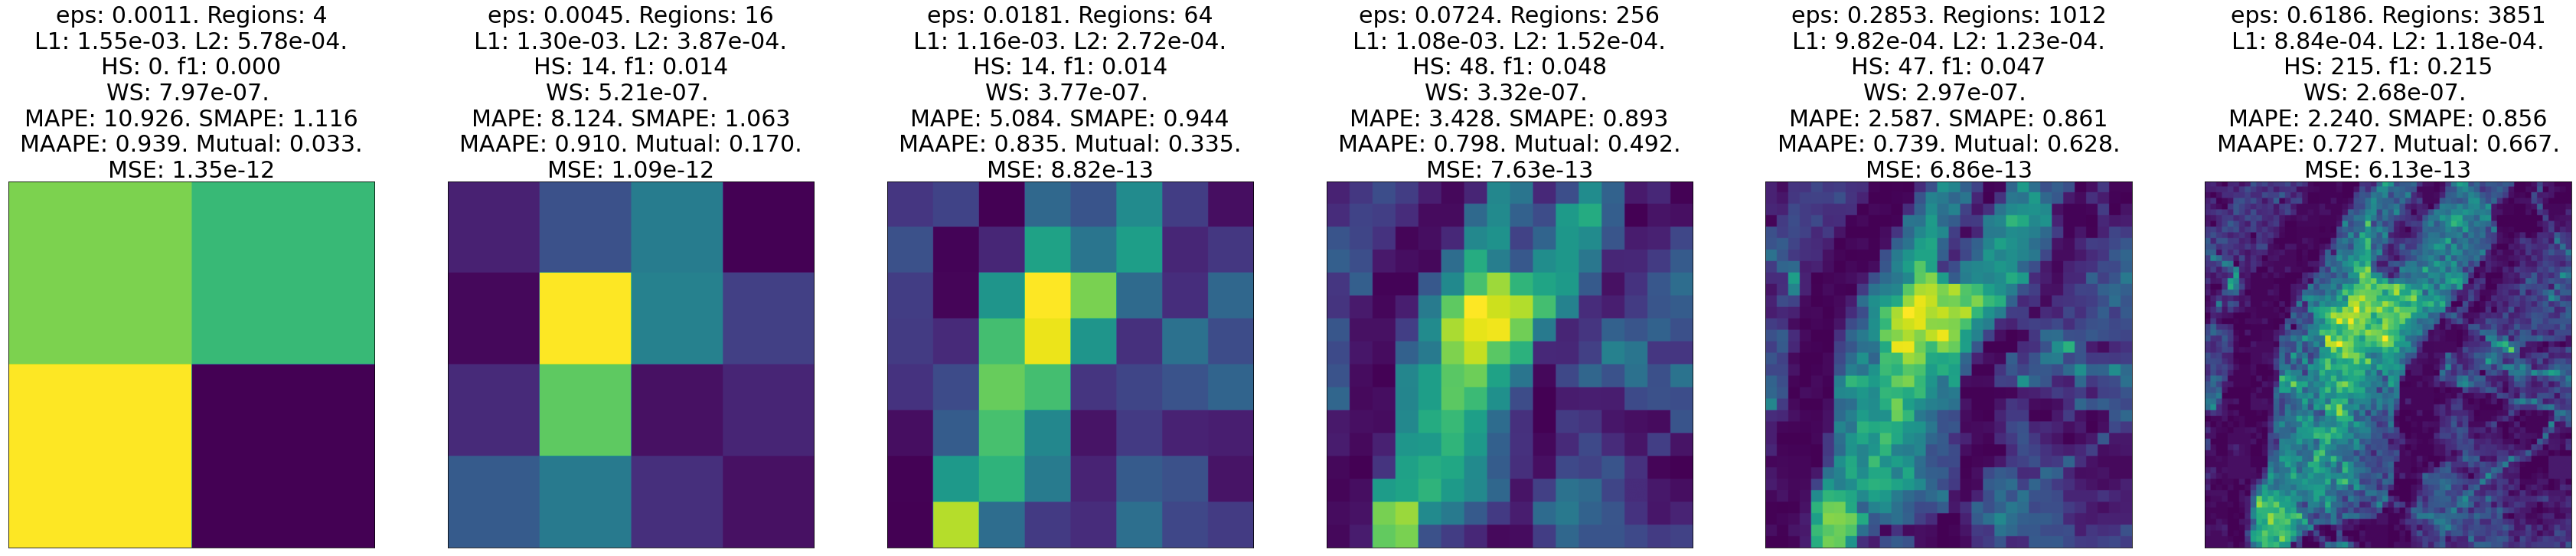

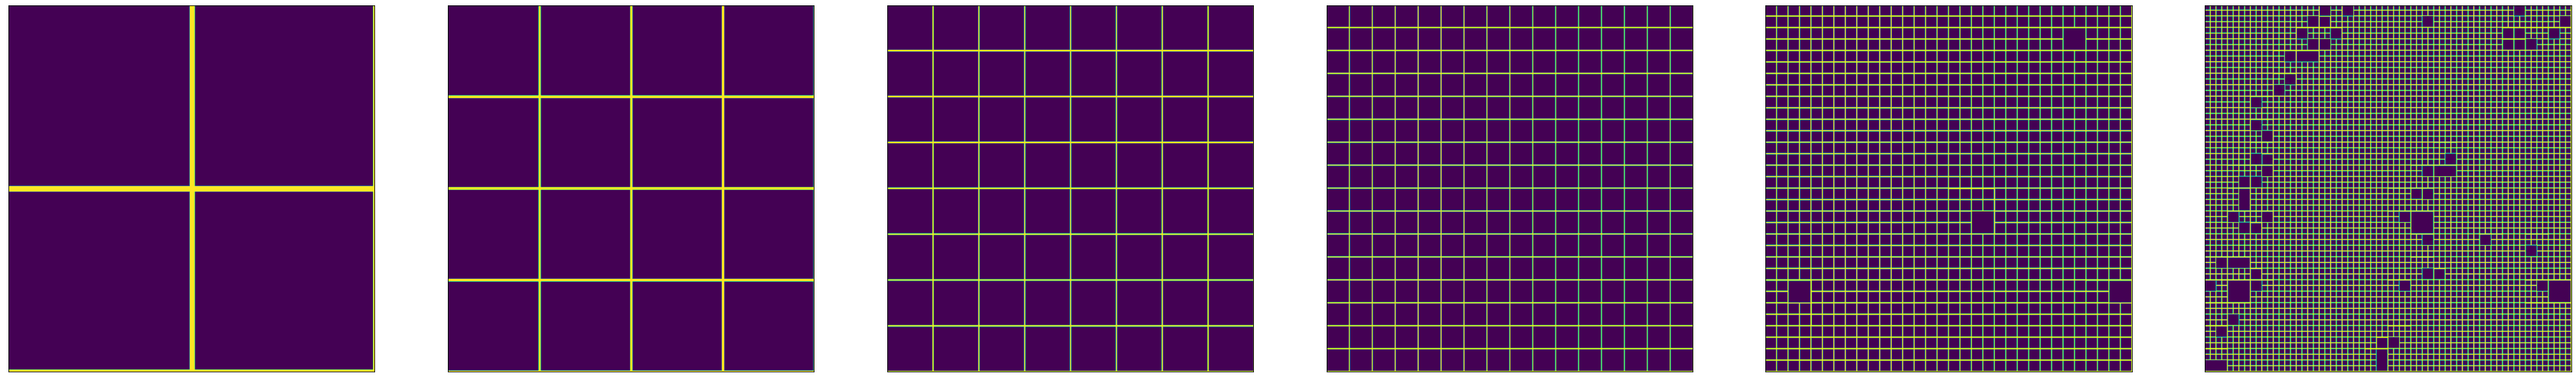

In [ ]:
# pretty slow
users = 1000000
secagg_size = 10000
c = 1/10
res1mln = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   split_threshold_func=lambda i, prefix_len, eps, remaining: 2 / np.sqrt(secagg_size / users) * mechanisms.get_std_from_eps( eps),
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   min_dp_size=9000,
                   dropout_rate=0.1,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   has_aux_bit=False, start_with_level=-1,
                   last_result_ci=False)


# Different datasets

In [ ]:
!wget https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/lagos.np
!wget https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/mayotte.np

--2021-07-12 17:04:26--  https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/lagos.np
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33555055 (32M)
Saving to: ‘lagos.np.1’

lagos.np.1          100%[===================>]  32.00M  23.3MB/s    in 1.4s    

2021-07-12 17:04:28 (23.3 MB/s) - ‘lagos.np.1’ saved [33555055/33555055]

--2021-07-12 17:04:28--  https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/mayotte.np
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10486383 (10M)
Saving to: ‘mayotte.np.1’

mayotte.np.1        100%[===================>]  10.00M  13.1MB/s    in 0.8s    

2021-07-12 17:04:30 (13.1 MB/s) - ‘mayotte.np.1’ sav

In [ ]:
mt = torch.load('mayotte.np')
lagos = torch.load('lagos.np')

lagos = lagos[1000:2024, 200:1224]
mt = mt[128:1152, :]

In [ ]:
lagos_dataset = geo_utils.convert_to_dataset(lagos, total_size=1024)
mt_dataset = geo_utils.convert_to_dataset(mt, total_size=1024)

100%|██████████| 1024/1024 [00:00<00:00, 1907.44it/s]


  0%|          | 0/100000 [00:00<?, ?it/s]

positivity: False
Total of 10.0 SecAgg rounds per level
Level: 0. Eps: 0.003577706855891111. Threshold: 8.62. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 0. MSE: 5.49e-11, without sampling error: 4.93e-11.
Level: 1. Eps: 0.014310712939686405. Threshold: 8.75. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 1. MSE: 5.41e-11, without sampling error: 4.85e-11.
Level: 2. Eps: 0.0482943748761969. Threshold: 9.24. Remaining: 0.98


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 2. MSE: 5.25e-11, without sampling error: 4.69e-11.
Level: 3. Eps: 0.17597500813930209. Threshold: 11.52. Remaining: 0.93


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 3. MSE: 4.90e-11, without sampling error: 4.34e-11.
Last round. Spending remaining epsilon budget: 75784.21971889236
Level: 4. Eps: 0.7578421971889236. Threshold: 11.52. Remaining: 0.76


Level: 4. MSE: 4.54e-11, without sampling error: 3.98e-11.
Total epsilon-users: 100000.00 with 1.00 eps per person. 


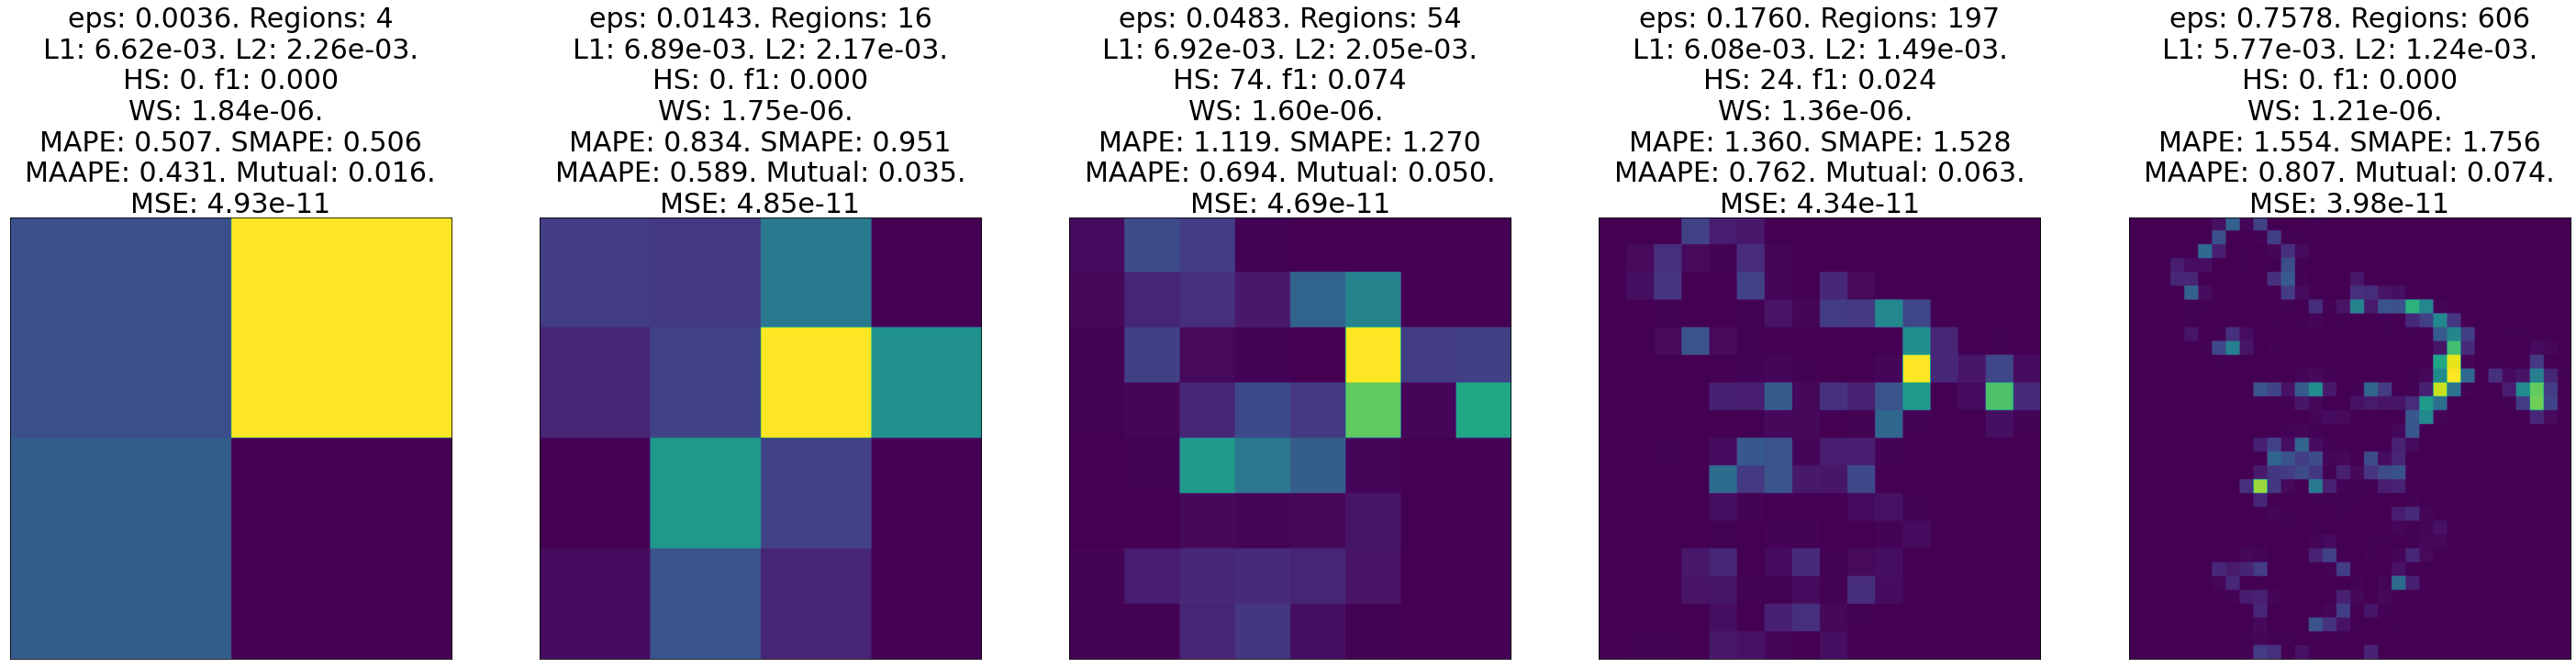

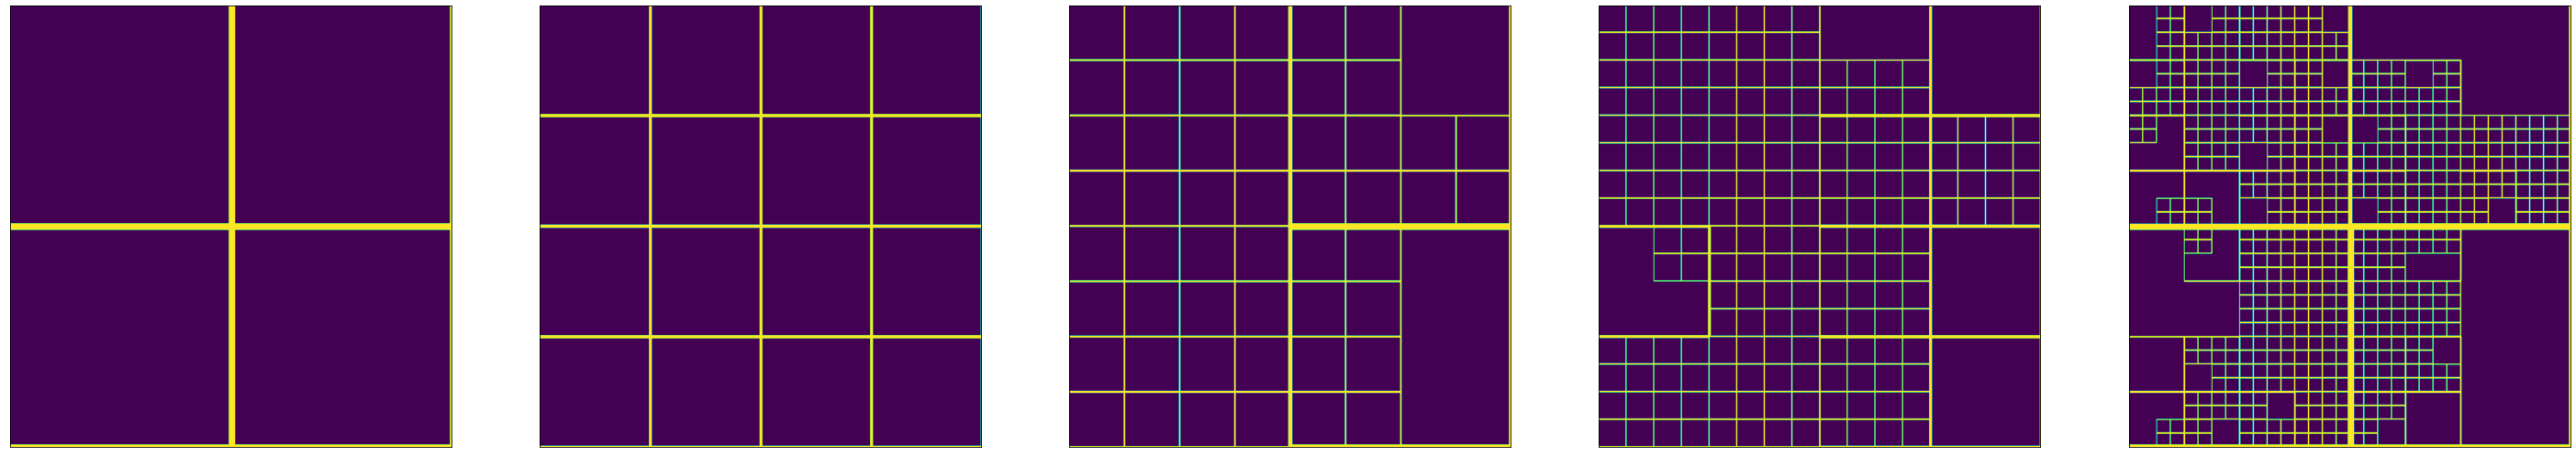

In [ ]:
          
users = 100000
secagg_size = 10000
c = secagg_size / users
res10 = run_experiment(mt,
                   mt_dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(1/10 * np.sqrt(c) * users/num_regions),
                   split_threshold_func=lambda i, prefix_len, eps, remaining: 2 / np.sqrt(c) * mechanisms.get_std_from_eps( max(eps, remaining)),
                   collapse_func=lambda threshold: threshold,
                   total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=1024,
                   min_dp_size=None,
                   dropout_rate=None,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   has_aux_bit=False, start_with_level=-1,
                   last_result_ci=False)

positivity: False
Total of 10.0 SecAgg rounds per level


  1%|          | 916/100000 [00:00<00:10, 9156.86it/s]

Level: 0. Eps: 0.003577706855891111. Threshold: 8.62. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 0. MSE: 1.22e-11, without sampling error: 4.95e-11.
Level: 1. Eps: 0.014310712939686405. Threshold: 8.75. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 1. MSE: 1.17e-11, without sampling error: 4.94e-11.
Level: 2. Eps: 0.05723552747969013. Threshold: 9.33. Remaining: 0.98


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 2. MSE: 1.14e-11, without sampling error: 4.97e-11.
Level: 3. Eps: 0.21158434856951708. Threshold: 12.28. Remaining: 0.92


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 3. MSE: 1.12e-11, without sampling error: 5.01e-11.
Last round. Spending remaining epsilon budget: 71329.17041552153
Level: 4. Eps: 0.7132917041552153. Threshold: 12.28. Remaining: 0.71


Level: 4. MSE: 1.09e-11, without sampling error: 5.04e-11.
Total epsilon-users: 100000.00 with 1.00 eps per person. 


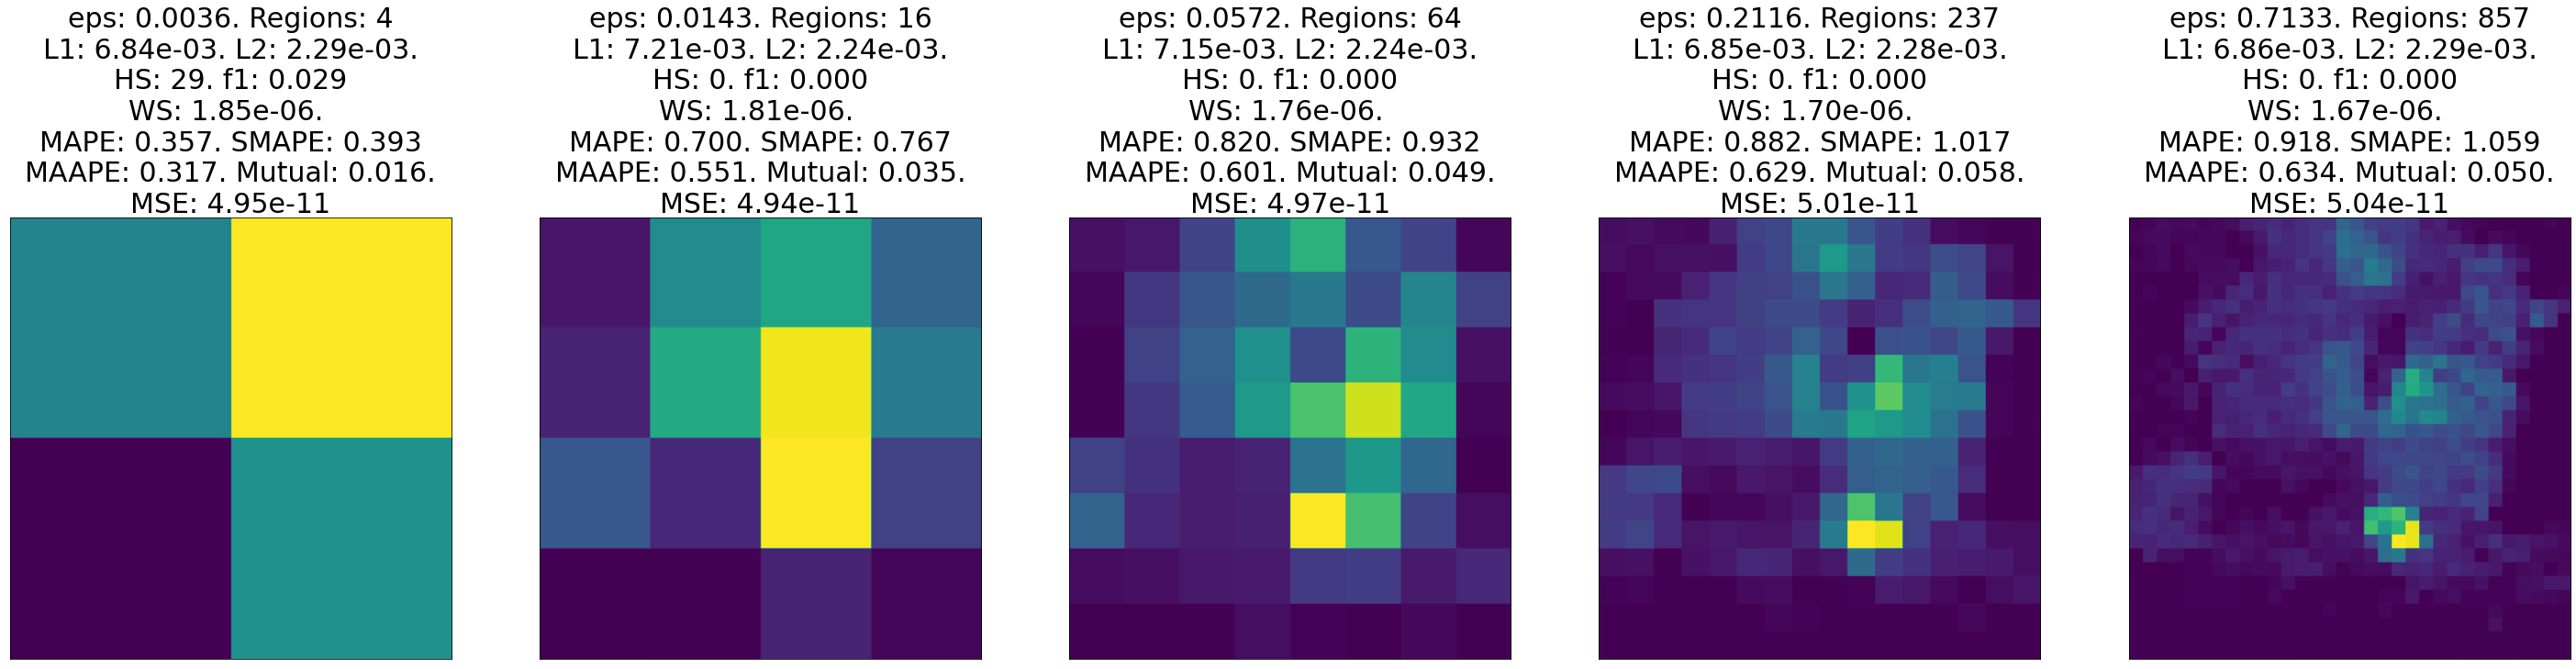

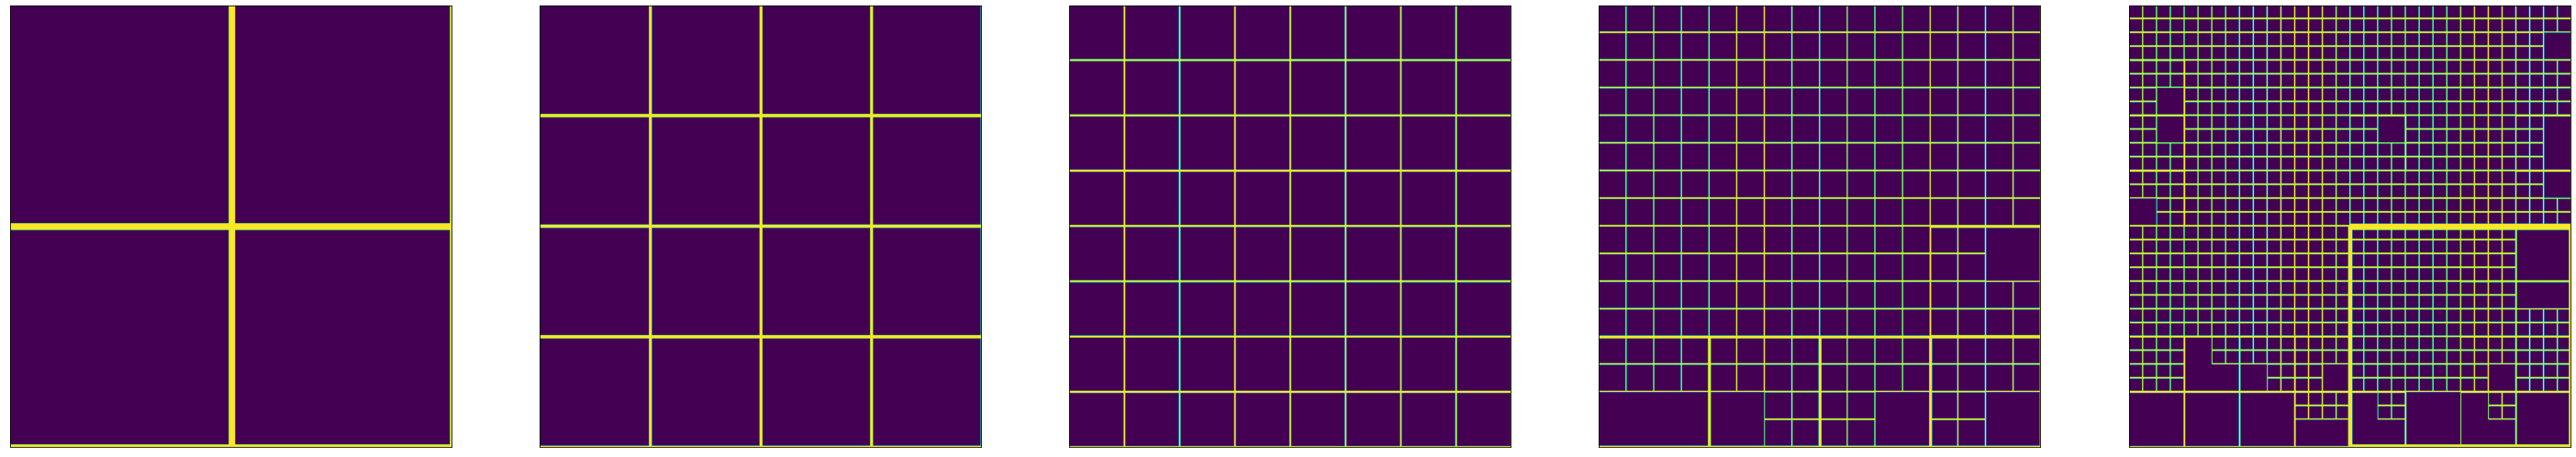

In [ ]:
          
users = 100000
secagg_size = 10000
c = secagg_size / users
res10 = run_experiment(lagos,
                   lagos_dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(1/10 * np.sqrt(c) * users/num_regions),
                   split_threshold_func=lambda i, prefix_len, eps, remaining: 2 / np.sqrt(c) * mechanisms.get_std_from_eps( max(eps, remaining)),
                   collapse_func=lambda threshold: threshold,
                   total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=1024,
                   min_dp_size=None,
                   dropout_rate=None,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   has_aux_bit=False, start_with_level=-1,
                   last_result_ci=False)